In [1]:
import numpy as np
import porespy as ps
import matplotlib.pyplot as plt
import scipy.io as sio
import skimage as ski
import tqdm
import seaborn as sns
import pandas as pd
from pathlib import Path
import pickle as pkl
from sklearn.neighbors import KernelDensity
from  scipy.stats import gaussian_kde


cwd = Path().resolve()

In [2]:
# Define overall variables used to analyze the data
resolution = 16.81E-6 # adding resolution in meters
lowFlowVelCutoff = 6.5 * 10 ** float(-6) #0.000207 # 5.13 * 10 ** float(-5) # 0.5 * 10 ** float(-5)
poreDiamThresh = 20
poreVolumeCutoff = 38000
simPressure = 0.00005 # This is currently hardcoded!!
imageSize = 512
experimentTime = 90 * 10 ** float(-6) # specify NMR time

filePath = cwd / 'subBeadPackPy512_justSpheres.npy'
primaryImage = np.load(filePath)

filePath = cwd / 'finalSimFile3D512.npy'
secondaryImage = np.load(filePath)
primaryImage[primaryImage == 255] = 1

primaryImage = np.transpose(primaryImage)
secondaryImage = np.transpose(secondaryImage)

filePath = cwd / 'primarySnowOut.npy'
primarySnow = np.load(filePath)
filePath = cwd / 'primaryPoreInfo.p'
#primaryInfo = np.load(filePath,allow_pickle=True)
poreInfoPrimary = pkl.load(open(filePath,'rb'))

filePath = cwd / 'secondarySnowOut.npy'
secondarySnow = np.load(filePath)
filePath = cwd / 'secondaryPoreInfo.p'
#secondaryInfo = np.load(filePath,allow_pickle=True)
poreInfoSecondary = pkl.load(open(filePath,"rb"))


In [3]:
filePath = cwd / 'velocityFiles' / 'velocityNormCodeSecondary_0.00005.mat'
velSecondaryMat = sio.loadmat(filePath)
velDataNormSecondary = velSecondaryMat['velNorm']

filePath = cwd / 'velocityFiles' / 'velocityNormCodePrimary_0.00005.mat'
velPrimaryMat = sio.loadmat(filePath)
velDataNormPrimary = velPrimaryMat['velNorm']


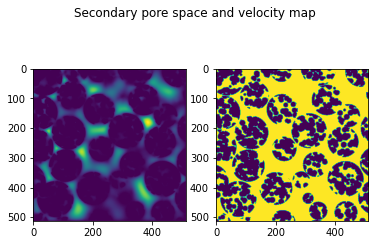

In [4]:
slice = 35

fig, (p1, p2) = plt.subplots(1, 2)

fig.suptitle('Secondary pore space and velocity map')
p1.imshow(velDataNormSecondary[:,:,slice])
p2.imshow(secondaryImage[:,:,slice])

fig.savefig('secondaryPoreImage.png', dpi=300, facecolor='w', edgecolor='w')

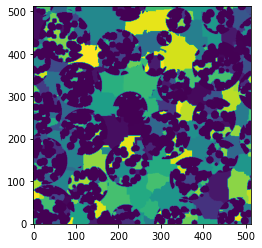

In [5]:
plt.imshow(ps.tools.randomize_colors(secondarySnow[:,:,slice]), origin='lower')
plt.savefig('secondaryRegions.png', dpi=300, facecolor='w', edgecolor='w')


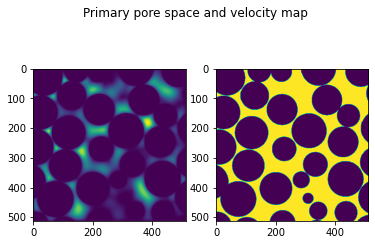

In [6]:
slice = 35

fig, (p1, p2) = plt.subplots(1, 2)

fig.suptitle('Primary pore space and velocity map')
p1.imshow(velDataNormPrimary[:,:,slice])
p2.imshow(primaryImage[:,:,slice])

fig.savefig('primaryPoreImage.png', dpi=300, facecolor='w', edgecolor='w')

### Load all the data

In [7]:
intraPoreMeanPoreVelocity = np.load('intraPore_meanVel.npy')
intraPore_metric_PoreVelocity = np.load('intraPore_metricVel.npy')
intraPoreVolumeVector = np.load('intraPoreVolumeVector.npy')
intraPoreVelocityDataframe = np.load('intraPoreVelocityDataframe.npy')
intraPoreVolumeDataframe = np.load('intraPoreVolumeDataframe.npy')

maskedSecondaryMeanPoreVelocity = np.load('maskedPore_meanVel.npy')
maskedSecondary_metric_PoreVelocity = np.load('maskedPore_metricVel.npy')
maskedSecondaryPoreVolumeVector = np.load('maskedPoreVolumeVector.npy')
maskedSecondaryPoreVolumeDataframe = np.load('maskedPoreVolumeDataframe.npy')
maskedSecondaryPoreVelocityDataframe = np.load('maskedPoreVelocityDataframe.npy')

df_secondaryVelocity = pd.read_pickle('secondaryVelocities.pkl')

## Format Dataframe


In [8]:
copyInterGrainPoreVol = np.array(df_secondaryVelocity["Intergrain Pore Volume"])
filtInterGrainVel = np.zeros(copyInterGrainPoreVol.shape)
for a in range(len(copyInterGrainPoreVol)):
    if np.isnan(copyInterGrainPoreVol[a]):
        filtInterGrainVel[a] = 0
    else:
        filtInterGrainVel[a] = copyInterGrainPoreVol[a]

In [9]:
df_secondaryVelocity["Intragrain Pore Volume"] = df_secondaryVelocity["Intragrain Pore Volume"] - filtInterGrainVel

In [10]:
df_secondaryVelocity

,All secondary regions,All secondary pore volumes,Median secondary pore velocity,Intragrain Pore Volume,Intragrain Median Velocity,Intergrain Pore Volume,Intergrain Median Velocity
0,0,0.0,0.000000e+00,NaN,NaN,NaN,NaN
1,1,1391.0,1.883050e-08,1391,1.88305e-08,NaN,NaN
2,2,5440.0,7.619900e-07,5440,7.6199e-07,NaN,NaN
3,3,52403.0,3.808600e-06,0,1.1715e-07,52403,4.3474e-06
4,4,214270.0,5.869350e-06,0,5.5721e-07,214270,6.947e-06
...,...,...,...,...,...,...,...
6388,6388,111.0,1.260050e-07,0,1.0832e-07,111,1.97475e-07
6389,6389,211.0,NaN,NaN,NaN,NaN,NaN
6390,6390,422.0,NaN,NaN,NaN,NaN,NaN
6391,6391,192.0,NaN,NaN,NaN,NaN,NaN


## Plot Pore Volume

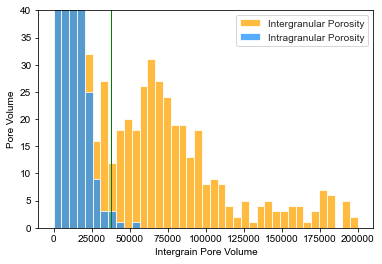

In [11]:
volumeBins = np.linspace(0, 200000, num=40)

fig, ax = plt.subplots()
sns.set_style('whitegrid')

sns.histplot(data=df_secondaryVelocity["Intergrain Pore Volume"],
     bins=volumeBins,color="orange", label="Intergranular Porosity")
sns.histplot(data=df_secondaryVelocity["Intragrain Pore Volume"],
     bins=volumeBins,color="dodgerblue", label="Intragranular Porosity")


#sns.displot(data=[df_secondaryVelocity["Intragrain Pore Volume"], df_secondaryVelocity["Intergrain Pore Volume"]],
#            bins=volumeBins)
plt.ylim([0,40])
plt.legend()
plt.ylabel('Pore Volume')

plt.plot([poreVolumeCutoff, poreVolumeCutoff],[0,200],'g',lw=1)

figStr = 'interAndIntraPoreVolume_pressure_'+str(simPressure)+'.png'

plt.savefig(figStr, dpi=300, facecolor='w', edgecolor='w')


## Plot inter and intragranular porosity


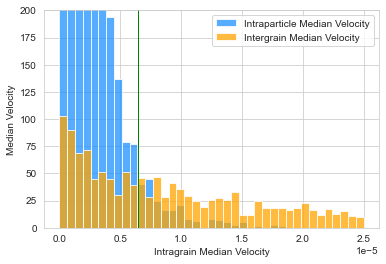

In [12]:
bins = np.linspace(0.000002, 0.00005, num=20)
#np.append(bins,0.0001)
bins = np.append(bins, 1000)
bins = np.insert(bins, 0, 0)
bins = np.insert(bins, 1, 0.00000001)
bins = np.insert(bins, 2, 0.0000001)
bins = np.insert(bins, 3, 0.000001)


binnedIntraVel = pd.cut(df_secondaryVelocity["Intragrain Median Velocity"], bins=bins, right=False)
binnedInterVel = pd.cut(df_secondaryVelocity["Intergrain Median Velocity"], bins=bins, right=False)
df_secondaryVelocity["binned_intraVelocity"] = binnedIntraVel
df_secondaryVelocity["binned_interVelocity"] = binnedIntraVel

yMax = 3000
velBins = np.linspace(0, 0.000025, num=40)

fig, ax = plt.subplots()
#fig.suptitle('Intra and inter pore velocities', fontsize=20)
sns.histplot(data=df_secondaryVelocity["Intragrain Median Velocity"],bins=velBins,
             ax=ax,color="dodgerblue", label="Intraparticle Median Velocity")
sns.histplot(data=df_secondaryVelocity["Intergrain Median Velocity"], bins=velBins,
             ax=ax, color="orange", label="Intergrain Median Velocity")
plt.legend()
ax.set_ylim([0,200])
ax.set_ylabel('Median Velocity')

lowFlowVelCutoff = 6.5 * 10 ** float(-6) #0.000207 # 5.13 * 10 ** float(-5) # 0.5 * 10 ** float(-5)
ax.plot([lowFlowVelCutoff , lowFlowVelCutoff],[0,200],'g',lw=1)

figStr = 'interAndIntraPoreVelocity_pressure_'+str(simPressure)+'.png'

fig.savefig(figStr, dpi=300, facecolor='w', edgecolor='w')



## Plot both pore volume and median velocity

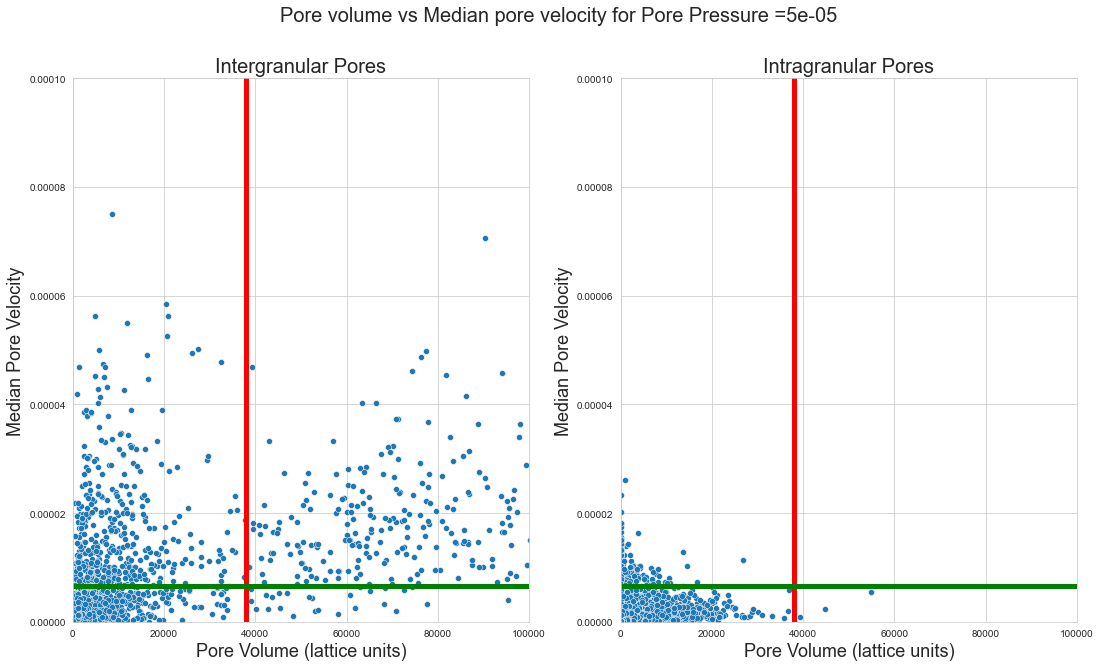

In [13]:
########################################

yMax = 0.0001
xMax = 100000#np.max(df_secondaryVelocity["Intergrain Pore Volume"])

fig, axes = plt.subplots(1, 2, figsize=(18, 10))
fig.suptitle('Pore volume vs Median pore velocity for Pore Pressure ='+str(simPressure), fontsize=20)
sns.scatterplot(data=df_secondaryVelocity,x="Intergrain Pore Volume", y='Intergrain Median Velocity',ax=axes[0])
axes[0].set_xlabel('Pore Volume (lattice units)', fontsize=18)
axes[0].set_ylabel('Median Pore Velocity', fontsize=18)
axes[0].set_title('Intergranular Pores', fontsize=20)
axes[0].set_ylim([0,yMax])
axes[0].set_xlim([0,xMax])
axes[0].plot([poreVolumeCutoff, poreVolumeCutoff],[0,yMax],'r',lw=5)
axes[0].plot([0,xMax],[lowFlowVelCutoff, lowFlowVelCutoff],'g',lw=5)

sns.scatterplot(data=df_secondaryVelocity, x="Intragrain Pore Volume", y='Intragrain Median Velocity',ax=axes[1])
axes[1].set_xlabel('Pore Volume (lattice units)', fontsize=18)
axes[1].set_ylabel('Median Pore Velocity', fontsize=18)
axes[1].set_title('Intragranular Pores', fontsize=20)
axes[1].set_ylim([0,yMax])
axes[1].set_xlim([0,xMax])
axes[1].plot([poreVolumeCutoff, poreVolumeCutoff],[0,yMax],'r',lw=5)
axes[1].plot([0,xMax],[lowFlowVelCutoff, lowFlowVelCutoff],'g',lw=5)

figStr = 'poreVolumeVsPoreVelocity_zoomIn'+'.png'

fig.savefig(figStr, dpi=300, facecolor='w', edgecolor='w')


In [14]:
df_secondaryVelocity.count()

All secondary regions             6393
All secondary pore volumes        6393
Median secondary pore velocity    6263
Intragrain Pore Volume            6221
Intragrain Median Velocity        6221
Intergrain Pore Volume            1423
Intergrain Median Velocity        1423
binned_intraVelocity              5951
binned_interVelocity              5951
dtype: int64

# IN PROGRESS RESEARCH BELOW

### Plot all pore velocities to add diffusion to

In [15]:
# filter by pore space
allVelocities = velDataNormSecondary[secondaryImage == True]
# smush into one dimension
allVelocities = np.squeeze(allVelocities)

In [16]:
np.max(allVelocities)

0.00012842

In [17]:
allDisplacements = allVelocities * resolution * experimentTime
#allDisplacementNorm = allVelocitiesNorm * resolution * experimentTime # this is now in units of length

In [18]:
np.max(allDisplacements)

1.94286618e-13

## Plot histogram of displacements from velocity simulation

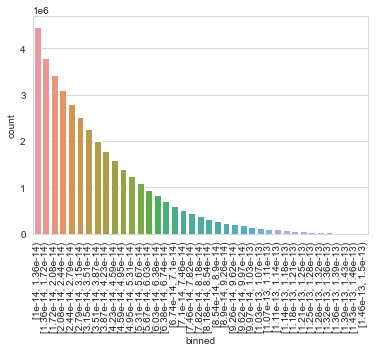

In [19]:
displacementBins = np.linspace(1e-14, 1.5e-13, num=40)
#np.append(bins,0.0001)


data={'Displacement (m)': allDisplacements}
df_displacement = pd.DataFrame(data=data)

df_displacement['binned'] = pd.cut(df_displacement['Displacement (m)'], bins=displacementBins, right=False)


ax = sns.countplot(data=df_displacement, x='binned')
ax.tick_params(axis='x', labelrotation=90)


## Scale simulated displacements to be close to diffusion

In [20]:
scaleExp = 9
allDisplacementsScaled = allDisplacements*(10**scaleExp);

## Simulate diffusion

In [21]:
D_0 = 2.023 * 10 ** float(-9) # (m^2/s) for water at twenty degrees Celsius
T = 90000 * 10 ** float(-6) # (s) for 90000 us, same as NMR experiment
diffusionLength = np.sqrt(2*D_0 * T)  # (m) Equation for diffusion in 2D
#diffusionVel = diffusionLength/T  # (m/s) Compute how fast diffusion is over T
print("The calculated diffusion length is ", diffusionLength, " m")

#randList = [-1,1]
#diffusionSign = np.random.choice(randList,len(df_secondaryVelocity["All secondary regions"]))
#diffusionDist = np.random.rand(len(df_secondaryVelocity["All secondary regions"]))

# FIXME: how is this defined really?m
# figure out sigma of diffusion distribution, currently sigma is set to diffusion length
#diffusionDist = np.random.normal(0,diffusionLength,len(allVelocities))

diffusionDist = (4*np.pi*D_0*T)*np.exp(allDisplacementsScaled**2/(4*D_0*T))
#diffusionDist = np.random.normal(0,diffusionLength,6000)
# This distribution is in m

The calculated diffusion length is  1.9082452672547102e-05  m


In [48]:
displacementBinsScaled = np.linspace(-2e-4, 2e-4, num=160)
#np.append(bins,0.0001)
#displacementBinsScaled = np.append(displacementBinsScaled, 3e-3)
#displacementBinsScaled = np.append(displacementBinsScaled, 5e-3)
#displacementBinsScaled = np.append(displacementBinsScaled, 7e-3)
#displacementBinsScaled = np.append(displacementBinsScaled, 1e-2)

#displacementBinsScaled = np.insert(displacementBinsScaled, 0, -1e-2)


In [49]:
np.max(allDisplacements)

1.94286618e-13

In [53]:
np.max(allDisplacementsScaled)

0.000194286618

In [54]:
simulatedDisplacementCounts, bins = np.histogram(allDisplacementsScaled, bins=displacementBinsScaled)
#simulatedDisplacementCounts = np.array(simulatedDisplacementCounts[0:1])
simulatedDisplacementCounts = simulatedDisplacementCounts / np.max(simulatedDisplacementCounts)
#simulatedDisplacementCounts = simulatedDisplacementCounts / simulatedDisplacementCounts[25]

diffusionCounts, bins = np.histogram(diffusionDist,bins=displacementBinsScaled)
#diffusionCounts = np.array(diffusionCounts[0:1])
diffusionCounts = diffusionCounts / np.max(diffusionCounts)
#diffusionCounts = diffusionCounts / diffusionCounts[25]


<BarContainer object of 159 artists>

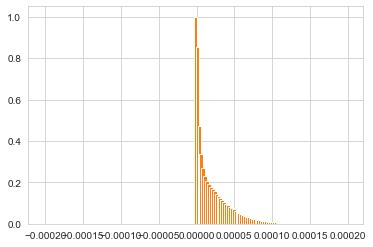

In [55]:
fig, ax = plt.subplots()

plt.bar(bins[:-1],diffusionCounts,width=5e-6)
plt.bar(bins[:-1],simulatedDisplacementCounts,width=5e-6)

#plt.hist(diffusionDist,bins=displacementBinsScaled)
#plt.hist(simulatedDisplacementCounts,bins=displacementBinsScaled)

## Load NMR data

In [24]:
filePath = cwd / 'summedNMRDisp.mat'
NMR_dispData = sio.loadmat(filePath)
NMRDisp = NMR_dispData['summedDispData']

filePath = cwd / 'dispVectorOut_inMeters.mat' # load disp vector in meters
NMRDispScaleTemp = sio.loadmat(filePath)
NMRDispScale = NMRDispScaleTemp['dispVectorOut']

NMRDispNorm = NMRDisp / np.max(NMRDisp)
NMRDispNorm = np.transpose(NMRDispNorm)
NMRDispScale = np.transpose(NMRDispScale)


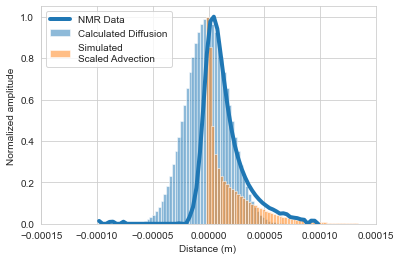

In [25]:
fig, ax = plt.subplots()

nPts = np.shape(NMRDispScale)
testScale = NMRDispScale * (1/(2 * np.pi))
#testSpace = np.linspace(-0.0001,0.0001,num=nPts[0])
ax.plot(testScale,NMRDispNorm, lw=4,  label='NMR Data')
#ax.plot(NMRDispScale,NMRDispNorm, lw=4,  label='NMR Data')
#ax.hist(diffusionCounts,bins=bins[:-1])

ax.bar(bins[:-1],diffusionCounts,width=3e-6,alpha=0.5,label='Calculated Diffusion')
ax.bar(bins[:-1],simulatedDisplacementCounts,width=3e-6,alpha=0.5,label="Simulated \nScaled Advection")

ax.set_xlabel("Distance (m) ")
ax.set_ylabel("Normalized amplitude")
ax.legend(loc=2)
ax.grid(True)
ax.set_xlim(-1.5e-4, 1.5e-4)
figStr = 'allSimDisp.png'
fig.savefig(figStr, dpi=300, facecolor='w', edgecolor='w')

In [154]:
np.max(bins)


0.0002

In [307]:
sns.barplot(x=displacementBinsScaled,y=simulatedDisplacementCounts[0])

plt.plot(NMRDispScale,NMRDisp)

figStr = 'allSimDisp.png'
#plt.savefig(figStr, dpi=300, facecolor='w', edgecolor='w')

AttributeError: 'bool' object has no attribute 'all'

In [23]:
test = np.digitize(simulatedDisplacement,displacementBinsScaled)
binCounts = np.bincount(test)

In [25]:
df_simulatedDisplacement

,Displacement (m)
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.000000
5,0.000000
6,0.000000
7,0.000000
8,0.000000
9,0.000000


In [85]:
temp = pd.value_counts(df_simulatedDisplacement['binned'])
displacementCounts = temp.tolist()

In [ ]:
temp[0]

In [84]:
displacementCountsScale = displacementCounts / np.max(displacementCounts)

AttributeError: 'numpy.ndarray' object has no attribute 'get'

In [82]:
tips = sns.load_dataset("tips")


In [77]:
temp2 = pd.cut(df_simulatedDisplacement['Displacement (m)'], bins=displacementBinsScaled, right=False, retbins=True)

In [68]:

displacementBins = temp2.tolist()

AttributeError: 'tuple' object has no attribute 'tolist'

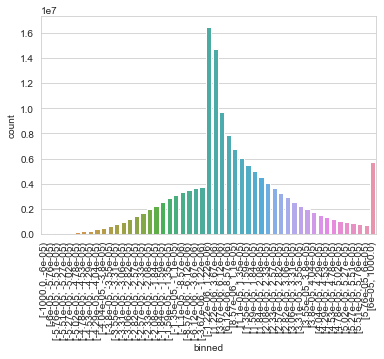

In [59]:
df_simulatedDisplacement['binned'] = pd.cut(df_simulatedDisplacement['Displacement (m)'], bins=displacementBinsScaled, right=False)


ax = sns.countplot(data=df_simulatedDisplacement, x='binned')
ax.tick_params(axis='x', labelrotation=90)




## Simulate diffusion

In [34]:
D_0 = 2.023 * 10 ** float(-9) # (m^2/s) for water at twenty degrees Celsius
T = 90 * 10 ** float(-3) # (s) for 90 ms, same as NMR experiment
diffusionLength = np.sqrt(2*D_0 * T)  # (m) Equation for diffusion in 2D
#diffusionVel = diffusionLength/T  # (m/s) Compute how fast diffusion is over T
print("The calculated diffusion length is ", diffusionLength, " m")

#randList = [-1,1]
#diffusionSign = np.random.choice(randList,len(df_secondaryVelocity["All secondary regions"]))
#diffusionDist = np.random.rand(len(df_secondaryVelocity["All secondary regions"]))

# FIXME: how is this defined really?
# figure out sigma of diffusion distribution, currently sigma is set to diffusion length
diffusionDist = np.random.normal(0,diffusionLength,len(allVelocities))
# This distribution is in m

The calculated diffusion length is  1.9082452672547102e-05  m


In [ ]:
# THIS IS VERY SLOW

fig, ax = plt.subplots()

sns.histplot(diffusionDist,kde=True)

figStr = 'diffDist'+'.png'
ax.set_xlabel("Diffusion Distance (m) ")
ax.set_ylabel("Frequency")
fig.savefig(figStr, dpi=300, facecolor='w', edgecolor='w')





In [66]:
 # sns.histplot(allVelocitiesNorm) # This command is slow

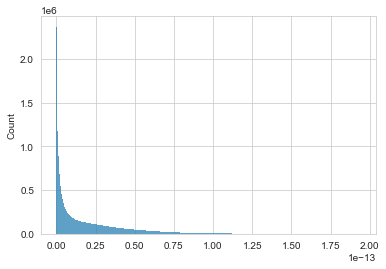

In [23]:
fig, ax = plt.subplots()

sns.histplot(allDisplacements)

figStr = 'simulatedDisplacement'+'.png'

fig.savefig(figStr, dpi=300, facecolor='w', edgecolor='w')

## Load NMR data

In [36]:
filePath = cwd / 'summedNMRDisp.mat'
NMR_dispData = sio.loadmat(filePath)
NMRDisp = NMR_dispData['summedDispData']

filePath = cwd / 'dispVectorOut_inMeters.mat' # load disp vector in meters
NMRDispScaleTemp = sio.loadmat(filePath)
NMRDispScale = NMRDispScaleTemp['dispVectorOut']

In [38]:
NMRDispPlot = np.transpose(NMRDisp)
NMRDispScalePlot = np.transpose(NMRDispScale)

Text(0, 0.5, 'NMR amplitude')

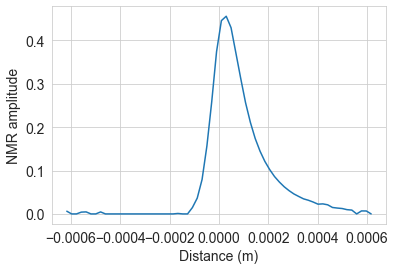

In [40]:
fig, ax = plt.subplots()

plt.plot(NMRDispScalePlot,NMRDispPlot)

ax.set_xlabel("Distance (m)")
ax.set_ylabel("NMR amplitude")

(array([5.619e+03, 3.550e+02, 1.650e+02, 7.100e+01, 3.000e+01, 1.300e+01,
        7.000e+00, 1.000e+00, 1.000e+00, 1.000e+00]),
 array([0.0000e+00, 7.3720e-06, 1.4744e-05, 2.2116e-05, 2.9488e-05,
        3.6860e-05, 4.4232e-05, 5.1604e-05, 5.8976e-05, 6.6348e-05,
        7.3720e-05]),
 <a list of 10 Patch objects>)

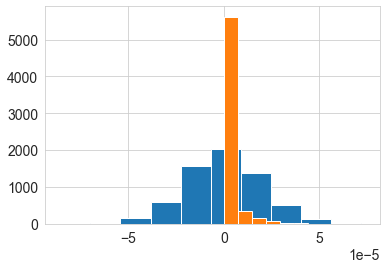

In [54]:
fig, ax = plt.subplots()

NMRData = NMRDispScalePlot
simulatedDiffusionData = diffusionDist
simulatedVelocityData = secondaryMedianVel

ax.hist(simulatedDiffusionData)
ax.hist(simulatedVelocityData)

In [ ]:
tmp_nmr = NMRDispScale - NMRDispScale.min()
ax.plot(displacement, tmp_nmr,axes=ax, label='NMR', lw=4)
ax.set_ylim(tmp_nmr.min(), tmp_nmr.max())
ax_1 = ax.twinx()
# ax_1.hist(allVelocitiesNorm[::10]*6 + 32, density=True, bins=20, alpha=0.5)
dummy = ax.hist(np.ones(5), alpha=0.5, label="Simulated", color='#1f77b4')
out = ax_1.hist(tmp, density=False, bins=np.linspace(0, 0.0006, 25), alpha=0.5)
# ax_1.hist(diffusionDistScale * 1e-3 + 0.0003, density=True, bins=np.linspace(0, 0.0006, 25), alpha=0.5)
ax_1.grid(False)
ax.set_xlabel("Scaled-distance ")
ax.set_ylabel("Normalized amplitude")
ax_1.set_ylabel("Normalized counts")
ax.legend(loc=2)
ax.set_xlim(displacement.min(), displacement.max())

ytikcs_sim = np.linspace(0, out[0].max(), 6)
ax_1.set_yticks(ytikcs_sim)
ax_1.set_yticklabels(["{:.1f}".format(x) for x in (np.arange(6)*0.2)])
xticks = ax.get_xticks()

ind_max = np.argmax(tmp_nmr)
zero_point = displacement[ind_max]
ax.set_xticks([zero_point])
ax.set_xticklabels(['0'])
ax.text(displacement[10], -0.1, '+', fontsize=16)
ax.text(displacement[-10], -0.1, '-', fontsize=16)
figStr = 'NMRDispHist'+'.png'
fig.savefig(figStr, dpi=300, facecolor='w', edgecolor='w')

In [ ]:
# np.where(secondaryVelPlusDiffusion[3] == np.nan)

In [ ]:
indices = [i for i in range(secondaryVelScale.size)]
secondaryVelScale = np.sort(secondaryVelScale)
secondaryVelScale = np.flip(secondaryVelScale)
plt.plot(indices,secondaryVelScale)


In [ ]:
secondaryVelPlusDiffusion = secondaryVelScale + diffusionDistScale

fig, ax = plt.subplots()

sns.histplot(secondaryVelPlusDiffusion,ax=ax,kde=True)

figStr = 'simDispHist'+'.png'

fig.savefig(figStr, dpi=300, facecolor='w', edgecolor='w')

In [ ]:
indices = np.where(np.isnan(secondaryVelPlusDiffusion), False, True)
secondaryVelPlusDiffusion = secondaryVelPlusDiffusion[indices]

In [ ]:
indices = [i for i in range(secondaryVelPlusDiffusion.size)]
plt.plot(indices,secondaryVelPlusDiffusion)

In [ ]:
testKDE = gaussian_kde(secondaryVelPlusDiffusion)
indices = np.random.rand(len(secondaryVelPlusDiffusion))
plotKDE = testKDE.evaluate(indices)

In [ ]:
plt.plot(indices,plotKDE)


In [ ]:
np.random.rand(10)

In [ ]:
filePath = cwd / 'summedNMRDisp.mat'
NMR_dispData = sio.loadmat(filePath)
NMRDisp = NMR_dispData['summedDispData']

In [ ]:
NMRDispScale = (NMRDisp - np.nanmean(NMRDisp)) / (np.nanmax(NMRDisp)-np.nanmin(NMRDisp))
NMRDispScale = np.transpose(NMRDispScale)
NMRDispScale = np.squeeze(NMRDispScale)

In [ ]:
indices = [i for i in range(NMRDispScale.size)]

In [ ]:
fig, ax = plt.subplots()

plt.plot(indices,NMRDispScale,axes=ax)

figStr = 'NMRDispHist'+'.png'

fig.savefig(figStr, dpi=300, facecolor='w', edgecolor='w')



# Calculate flowing fraction for this data

In [ ]:
intergrainPoreCount = df_secondaryVelocity["Intergrain Pore Volume"].count()
print('Number of inter particle pores is',str(intergrainPoreCount))

# Final porosity calculation
porosityCalc = ps.metrics.porosity(secondaryImage)
print('Total porosity:')
print(np.round(porosityCalc,2))

# Get grains
flippedImage = np.copy(secondaryImage)
flippedImage[secondaryImage == 1] = 0
flippedImage[secondaryImage == 0] = 1

### Refer to other code for less/more mobile calculation
## lowFlowCompute.py
